# **Import & Function**

In [3]:
import scipy
from scipy.io import loadmat
from pandas import factorize
import os
import pickle
import numpy as np
import random
from scipy import signal

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
# import seaborn as sns

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Classification for Channel Coding
# ch_code = ["BCH_7_4", "HAMM_7_4", "RS_7_3", "CONV_23_35", "POLAR"]
# ch_code = ["BCH_7_4", "TURBO_5_7_7", "CONV_23_35"]
ch_code = ["CONV_5_7", "CONV_13_17", "CONV_23_35"]
classes = ch_code

In [5]:
from datetime import datetime
now = datetime.now()

# Set path for saving result images
save_result_dir = r"C:\Users\USER-PC\haneol"

In [6]:
import os
import scipy.io
import numpy as np

def load_dataset(data, snr_range):
    """
    This function loads and processes a dataset represented as a dictionary with keys as tuples of channel codes and SNR values.

    Parameters:
    - data: A dictionary where keys are tuples representing channel codes and SNR values, and values are corresponding data arrays.
    - snr_range: A tuple specifying the range of SNR values to consider.

    Returns:
    A tuple containing:
    - snrs: List of sorted SNR values within the specified range.
    - X: Stacked data arrays corresponding to each channel code and SNR.
    - ch_codes: List of sorted channel codes.
    - one_hot_encode: One-hot encoded representation of channel codes.
    - lbl_SNR: Array of SNR values corresponding to each data vector.
    """

    # 각 ndarray 요소를 set으로 변환하여 정렬
    ch_codes = sorted(set([key[0] for key in data.keys()]))

    # 각 ndarray 요소를 set으로 변환하여 정렬
    snrs = sorted(set([key[1] for key in data.keys() if snr_range[0] <= key[1] <= snr_range[1]]))


    X = []; I = []; Q = []; lbl = [];

    for ch_code in ch_codes:
        for snr in snrs:
            X.append(data[(ch_code, snr)])
            for i in range(data[(ch_code, snr)].shape[0]):
                lbl.append((ch_code, snr))

    X = np.vstack(X); lbl=np.vstack(lbl)

    print(X.shape)

    # X = np.transpose(X[:,:,:],(0,2,1))


    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        ch_code = (lbl[i,0])
        Y.append(ch_code)

    mapping = {}
    for x in range(len(ch_codes)):
        mapping[ch_codes[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(ch_codes)/len(snrs)
    repeat_n_ch_code = len(ch_codes)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_ch_code)

    return snrs, X, ch_codes, one_hot_encode, lbl_SNR

In [7]:
def train_test_valid_split(X, one_hot, train_split=0.8, valid_split=0.1, test_split=0.1):

    """
    Train-Test-Valid split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.8)
        valid_split (default 0.1)
        test_split (default 0.1)
        train_split : valid_split : test_split - ratio for splitting the dataset

        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)

    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))

    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)

    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)

    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test

## Transformer

In [8]:
# Positional encoding
def position_encoding_init(n_position, emb_dim):
    ''' Init the sinusoid position encoding table '''

    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / emb_dim) for j in range(emb_dim)]
        if pos != 0 else np.zeros(emb_dim) for pos in range(n_position)])


    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1

    return position_enc

In [9]:
# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# **Plot Result**

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, labels=[], title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function generates and displays a confusion matrix plot using Matplotlib.

    Parameters:
    - cm: Confusion matrix, a 2D numpy array where rows represent true labels and columns represent predicted labels.
    - labels: List of labels for different classes (optional, default is an empty list).
    - title: Title for the confusion matrix plot (optional, default is 'Confusion matrix').
    - cmap: Colormap for the plot (optional, default is plt.cm.Blues).

      This function creates a visual representation of a confusion matrix, which is a table used to evaluate the performance of a classification algorithm.

      The confusion matrix is passed as the 'cm' parameter, and optional parameters allow customization of the plot appearance.

      The plot includes color-coded cells representing the elements of the confusion matrix, a colorbar for reference, and text annotations displaying the numerical values at each matrix position.

      The text color is dynamically set to white or black based on the magnitude of each value.

      Additionally, the plot can be saved as a PNG file, but the saving location ('save_result_dir') is not provided in this code snippet and should be defined before using the function.

    Example usage:
      plot_confusion_matrix(confusion_matrix_data, labels=['Class1', 'Class2', 'Class3'], title='Model Performance')
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(save_result_dir + 'Confusion_matrix' + '.png')

In [11]:
def SNR_accuracy(in_snr, model, name):
    """
    Computes accuracies of chosen SNRs individualy

    INPUT : 
        in_snr: It means SNR_RANGE.  must be list of SNRs
        model : Trained model 
        name : Model name
    """

    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR_t[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(in_snr, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 21, 2)
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10)
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=10)


    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-21, 21)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
    plt.savefig(save_result_dir + name + '.png')
    plt.show()

    return acc[:,1]


# **Dataset load**

In [12]:
import re
from tqdm import tqdm, trange


### SNR 범위 수정 
snr = range(-20, 21, 1)
### 데이터 셋 저장 폴더 수정
base = r"C:\Users\USER-PC\haneol\DATASET_HW" # PYTHON VERSION
# base = r"C:\Users\USER-PC\haneol\DATASET_CONV" # MATLAB VERSION

all_data= {}

for i in tqdm(snr, desc="Loading Files"):
    print("Now load SNR: " + str(i))

    base_dir = base + "\\" + str(i)

    # 디렉토리 내의 모든 .npy 파일 목록 가져오기
    files = [f for f in os.listdir(base_dir) if f.endswith('.npy')]

    label_data = {}

    # 각 .mat 파일에 대해
    for file in tqdm(files, desc=f"SNR {i}", position=0, leave=False):
        # 절대 경로 생성하기
        filepath = os.path.join(base_dir, file)

        # .npy 데이터
        npy_data = np.load(filepath)

        # ch_code 값 추출하기 (예시: 문자열로 변환하여 추출)
        ch_code_value = re.sub(r'_\d+\.npy', '', file)

        # Key에 따라 저장
        key = (ch_code_value, i)
        if key not in label_data:
            label_data[key] = [npy_data]
        else:
            label_data[key].append(npy_data)


    for key in label_data.keys():
        all_data[key] = np.stack(label_data[key], axis=0)

Loading Files:   0%|          | 0/41 [00:00<?, ?it/s]

Now load SNR: -20


Loading Files:   2%|▏         | 1/41 [00:01<01:04,  1.60s/it]

Now load SNR: -19


Loading Files:   5%|▍         | 2/41 [00:03<01:03,  1.63s/it]

Now load SNR: -18


Loading Files:   7%|▋         | 3/41 [00:04<01:00,  1.60s/it]

Now load SNR: -17


Loading Files:  10%|▉         | 4/41 [00:06<00:59,  1.59s/it]

Now load SNR: -16


Loading Files:  12%|█▏        | 5/41 [00:08<00:57,  1.61s/it]

Now load SNR: -15


Loading Files:  15%|█▍        | 6/41 [00:09<00:56,  1.60s/it]

Now load SNR: -14


Loading Files:  17%|█▋        | 7/41 [00:11<00:54,  1.60s/it]

Now load SNR: -13


Loading Files:  20%|█▉        | 8/41 [00:12<00:53,  1.61s/it]

Now load SNR: -12


Loading Files:  22%|██▏       | 9/41 [00:14<00:51,  1.60s/it]

Now load SNR: -11


Loading Files:  24%|██▍       | 10/41 [00:15<00:49,  1.59s/it]

Now load SNR: -10


Loading Files:  27%|██▋       | 11/41 [00:17<00:47,  1.58s/it]

Now load SNR: -9


Loading Files:  29%|██▉       | 12/41 [00:19<00:46,  1.59s/it]

Now load SNR: -8


Loading Files:  32%|███▏      | 13/41 [00:20<00:44,  1.58s/it]

Now load SNR: -7


Loading Files:  34%|███▍      | 14/41 [00:22<00:42,  1.58s/it]

Now load SNR: -6


Loading Files:  37%|███▋      | 15/41 [00:23<00:41,  1.60s/it]

Now load SNR: -5


Loading Files:  39%|███▉      | 16/41 [00:25<00:39,  1.59s/it]

Now load SNR: -4


Loading Files:  41%|████▏     | 17/41 [00:27<00:38,  1.59s/it]

Now load SNR: -3


Loading Files:  44%|████▍     | 18/41 [00:28<00:36,  1.59s/it]

Now load SNR: -2


Loading Files:  46%|████▋     | 19/41 [00:30<00:35,  1.59s/it]

Now load SNR: -1


Loading Files:  49%|████▉     | 20/41 [00:31<00:33,  1.58s/it]

Now load SNR: 0


Loading Files:  51%|█████     | 21/41 [00:33<00:31,  1.57s/it]

Now load SNR: 1


Loading Files:  54%|█████▎    | 22/41 [00:35<00:30,  1.59s/it]

Now load SNR: 2


Loading Files:  56%|█████▌    | 23/41 [00:36<00:28,  1.59s/it]

Now load SNR: 3


Loading Files:  59%|█████▊    | 24/41 [00:38<00:26,  1.58s/it]

Now load SNR: 4


Loading Files:  61%|██████    | 25/41 [00:39<00:25,  1.59s/it]

Now load SNR: 5


Loading Files:  63%|██████▎   | 26/41 [00:41<00:23,  1.56s/it]

Now load SNR: 6


Loading Files:  66%|██████▌   | 27/41 [00:42<00:21,  1.55s/it]

Now load SNR: 7


Loading Files:  68%|██████▊   | 28/41 [00:44<00:20,  1.55s/it]

Now load SNR: 8


Loading Files:  71%|███████   | 29/41 [00:45<00:18,  1.55s/it]

Now load SNR: 9


Loading Files:  73%|███████▎  | 30/41 [00:47<00:17,  1.55s/it]

Now load SNR: 10


Loading Files:  76%|███████▌  | 31/41 [00:49<00:15,  1.55s/it]

Now load SNR: 11


Loading Files:  78%|███████▊  | 32/41 [00:50<00:13,  1.54s/it]

Now load SNR: 12


Loading Files:  80%|████████  | 33/41 [00:52<00:12,  1.53s/it]

Now load SNR: 13


Loading Files:  83%|████████▎ | 34/41 [00:53<00:10,  1.53s/it]

Now load SNR: 14


Loading Files:  85%|████████▌ | 35/41 [00:55<00:09,  1.54s/it]

Now load SNR: 15


Loading Files:  88%|████████▊ | 36/41 [00:56<00:07,  1.55s/it]

Now load SNR: 16


Loading Files:  90%|█████████ | 37/41 [00:58<00:06,  1.57s/it]

Now load SNR: 17


Loading Files:  93%|█████████▎| 38/41 [00:59<00:04,  1.57s/it]

Now load SNR: 18


Loading Files:  95%|█████████▌| 39/41 [01:01<00:03,  1.57s/it]

Now load SNR: 19


Loading Files:  98%|█████████▊| 40/41 [01:03<00:01,  1.57s/it]

Now load SNR: 20


Loading Files: 100%|██████████| 41/41 [01:04<00:00,  1.57s/it]


# **Load Data**

In [13]:
# Train , Valid
SNR_tv, X_tv, Ch_Codes_tv, one_hot_tv, lbl_SNR_tv = load_dataset(all_data, (-20, 20))

(61500, 128, 1)


In [14]:
# Test
SNR_t, X_t, Ch_Codes_t, one_hot_t, lbl_SNR_t = load_dataset(all_data, (-20, 20))

(61500, 128, 1)


**Train_Test_Valid Split**

상단 코드에서 Train , Valid 분리

하단 코드에서 Test 분리

In [15]:
train_idx, valid_idx, none_1, X_train, X_valid, none_2, Y_train, Y_valid, none_3 = train_test_valid_split(X_tv, one_hot_tv, train_split=0.8, valid_split=0.1, test_split=0.1)

In [16]:
none_4, none_5, test_idx, none_6, none_7, X_test, none_8, none_9, Y_test = train_test_valid_split(X_t, one_hot_t, train_split=0.9, valid_split=0.0, test_split=0.1)

In [17]:
print(X_train.shape)
print(Y_test.shape)
print(X_test.shape)
print(X_valid.shape)

(49200, 128, 1)
(6150, 3)
(6150, 128, 1)
(6150, 128, 1)


# **Model**

## **MCTransformer**

In [111]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer

inputs = keras.layers.Input(shape=(128, 1))
x = keras.layers.Conv1D(filters=embed_dim, kernel_size=8, activation='relu')(inputs) #(~, 121, 64)
x = keras.layers.MaxPool1D(pool_size=2)(x) #(~, 60, 64)
# x = keras.layers.LSTM(embed_dim, return_sequences=True,)(x) #(~, )
# x = keras.layers.Dropout(0.4)(x)

pos_emb = position_encoding_init(60, 64)
x_pos = x + pos_emb

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x_pos,  training="training")

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(len(ch_code), activation="softmax")(x)

model_MCT = keras.Model(inputs=inputs, outputs=outputs)

In [112]:
model_MCT.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 121, 64)        │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 60, 64)         │        68,752 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,691 (276.14 KB)

 Trainable params: 70,691 (276.14 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)
model_MCT.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [114]:
# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=5) # val_loss가 연속적으로 5회 이상 감소하지 않으면 작동

In [115]:
history = model_MCT.fit(X_train, Y_train, batch_size=256, epochs=50, validation_data=(X_valid, Y_valid), callbacks=[es])

Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.3338 - loss: 1.1116 - val_accuracy: 0.3380 - val_loss: 1.0986
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.3300 - loss: 1.0987 - val_accuracy: 0.3280 - val_loss: 1.0988
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.3344 - loss: 1.0987 - val_accuracy: 0.3280 - val_loss: 1.0987
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.3364 - loss: 1.0986 - val_accuracy: 0.3280 - val_loss: 1.0988
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.3319 - loss: 1.0987 - val_accuracy: 0.3280 - val_loss: 1.0987
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.3356 - loss: 1.0987 - val_accuracy: 0.3280 - val_loss: 1.0989


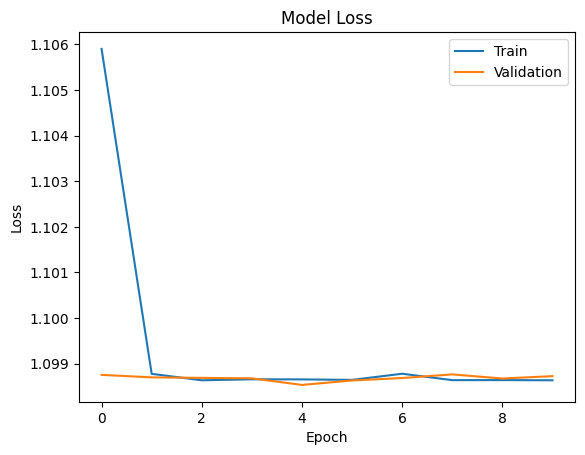

In [ ]:
# 학습 손실과 검증 손실의 추이 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Evaluate model
test_loss, test_acc = model_MCT.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3224 - loss: 1.0987
Test accuracy 0.32968252897262573
Test loss 1.0986523628234863


197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


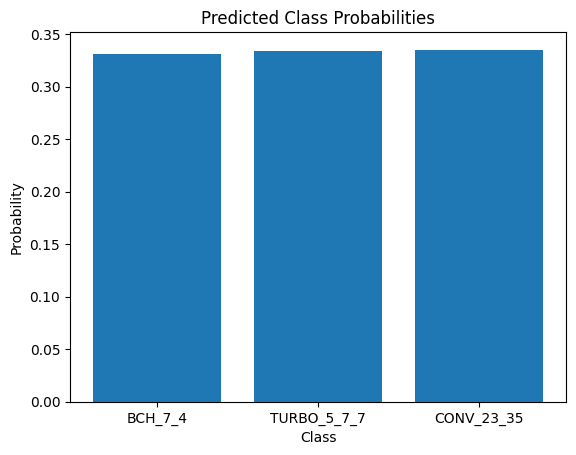

In [ ]:
# Check predict calsprobabilities
Y_predict = model_MCT.predict(X_test)

result_array = np.array(Y_predict)

class_labels = ch_code

rand = random.randrange(0, len(Y_predict)-1)

# 막대 그래프 생성
plt.bar(class_labels, result_array[rand])

# 축 및 제목 설정
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Predicted Class Probabilities')

# 그래프 출력
plt.show()

In [ ]:
# Calculate confusion matrix
conf = np.zeros([len(ch_code),len(ch_code)])
confnorm = np.zeros([len(ch_code),len(ch_code)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(Y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(ch_code)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

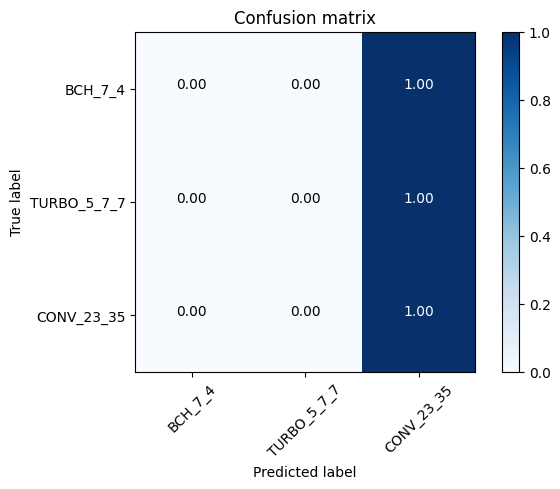

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(confnorm, labels=classes)


SNR -20dB:
10/10 - 0s - 49ms/step - accuracy: 0.3231 - loss: 1.0982

SNR -18dB:
10/10 - 0s - 13ms/step - accuracy: 0.3017 - loss: 1.0991

SNR -16dB:
11/11 - 0s - 13ms/step - accuracy: 0.3176 - loss: 1.0985

SNR -14dB:
9/9 - 0s - 14ms/step - accuracy: 0.3264 - loss: 1.0985

SNR -12dB:
10/10 - 0s - 13ms/step - accuracy: 0.3645 - loss: 1.0984

SNR -10dB:
11/11 - 0s - 13ms/step - accuracy: 0.2857 - loss: 1.0990

SNR -8dB:
10/10 - 0s - 13ms/step - accuracy: 0.3065 - loss: 1.0989

SNR -6dB:
10/10 - 0s - 13ms/step - accuracy: 0.3116 - loss: 1.0983

SNR -4dB:
10/10 - 0s - 13ms/step - accuracy: 0.3278 - loss: 1.0986

SNR -2dB:
9/9 - 0s - 14ms/step - accuracy: 0.3404 - loss: 1.0985

SNR 0dB:
10/10 - 0s - 13ms/step - accuracy: 0.3388 - loss: 1.0991

SNR 2dB:
10/10 - 0s - 13ms/step - accuracy: 0.2901 - loss: 1.0993

SNR 4dB:
10/10 - 0s - 13ms/step - accuracy: 0.3230 - loss: 1.0991

SNR 6dB:
10/10 - 0s - 14ms/step - accuracy: 0.3714 - loss: 1.0983

SNR 8dB:
9/9 - 0s - 14ms/step - accuracy: 0.3907 

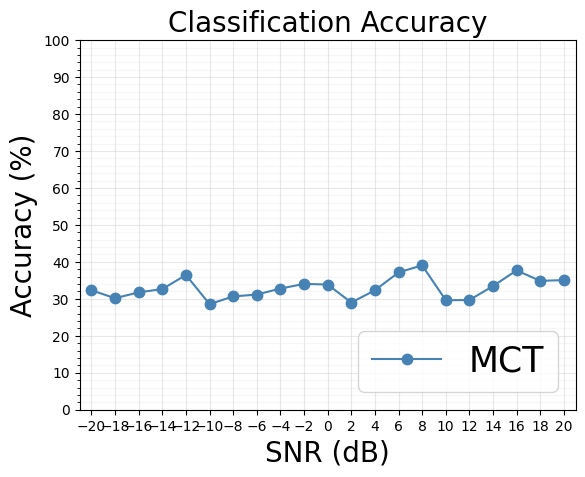

In [ ]:
# Plot classfication accuracy by each SNR
acc = SNR_accuracy(snr, model_MCT, 'MCT')

# **CNN**

In [116]:
cnn_in = keras.layers.Input(shape=(128, 1))
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)
cnn = keras.layers.Flatten()(cnn)
cnn = keras.layers.Dense(72, activation='relu')(cnn)
cnn = keras.layers.Dense(36, activation='relu')(cnn)
cnn_out = keras.layers.Dense(len(ch_code), activation='softmax')(cnn)

model_cnn = keras.models.Model(cnn_in, cnn_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [117]:
model_cnn.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_4                │ (None, 136, 1)         │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 129, 50)        │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 64, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 57, 50)         │        20,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 28, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 28, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 25, 50)         │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 72)             │        43,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 36)             │         2,628 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,561 (299.07 KB)

 Trainable params: 76,561 (299.07 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
history_CNN = model_cnn.fit(X_train, Y_train, batch_size=256, epochs=100, verbose=1, validation_data=(X_valid, Y_valid), callbacks=[es])

Epoch 1/100


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3385 - loss: 1.0996 - val_accuracy: 0.3311 - val_loss: 1.0995
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3355 - loss: 1.0988 - val_accuracy: 0.4416 - val_loss: 1.0948
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4248 - loss: 1.0327 - val_accuracy: 0.5211 - val_loss: 0.9119
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4956 - loss: 0.9279 - val_accuracy: 0.5379 - val_loss: 0.8908
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5586 - loss: 0.8811 - val_accuracy: 0.6096 - val_loss: 0.7981
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6064 - loss: 0.7998 - val_accuracy: 0.6190 - val_loss: 0.7772
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6262 - loss: 0.7651 - val_accuracy: 0.6317 - val_loss: 0.7471
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6377 - loss: 0.7417 - val_accuracy

In [119]:
model_cnn.save('Model_CNN_2.keras')

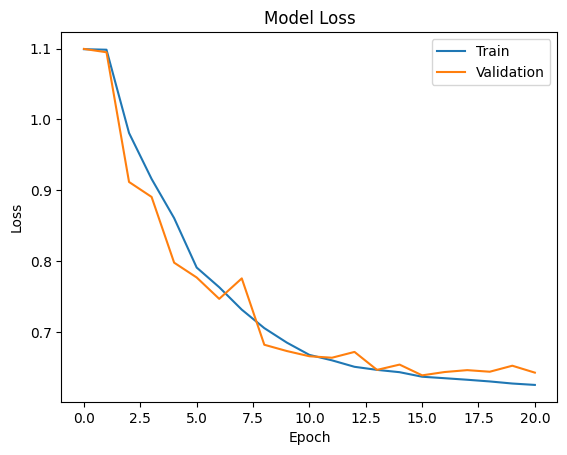

In [120]:
# Plot model loss (Train loss and Valid loss)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [121]:
# Evaluate model
test_loss, test_acc = model_cnn.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6407 - loss: 0.6395
Test accuracy 0.6413007974624634
Test loss 0.6445615887641907


193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


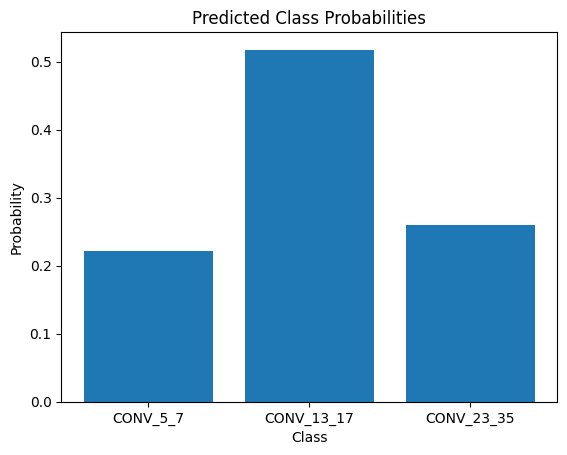

In [122]:
# Check predict calsprobabilities
Y_predict = model_cnn.predict(X_test)

result_array = np.array(Y_predict)

class_labels = ch_code

rand = random.randrange(0, len(Y_predict)-1)

# 막대 그래프 생성
plt.bar(class_labels, result_array[rand])

# 축 및 제목 설정
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Predicted Class Probabilities')

# 그래프 출력
plt.show()

In [123]:
from sklearn.metrics import accuracy_score

# 각 행에서 최대값의 인덱스를 찾아서 1로 나머지를 0으로 설정
Y_onehot = np.zeros_like(Y_predict)
Y_onehot[np.arange(len(Y_predict)), Y_predict.argmax(axis=1)] = 1

# Y_test와 Y_predict(Y_onehot) 비교
accuracy = accuracy_score(Y_test, Y_onehot)
print("Accuracy:", accuracy)

Accuracy: 0.6413008130081301


# **Confusion Matrix**

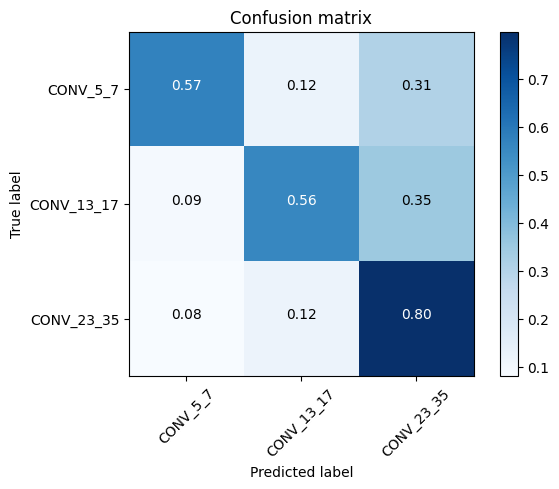

In [124]:
# Confusion matrix를 계산
conf = np.zeros([len(ch_code),len(ch_code)])
confnorm = np.zeros([len(ch_code),len(ch_code)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(Y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(ch_code)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
# Confusion matrix를 출력
plot_confusion_matrix(confnorm, labels=classes)

# **SNR Accuracy**


SNR -20dB:
5/5 - 0s - 41ms/step - accuracy: 0.3015 - loss: 1.1495

SNR -19dB:
5/5 - 0s - 6ms/step - accuracy: 0.2889 - loss: 1.1320

SNR -18dB:
5/5 - 0s - 6ms/step - accuracy: 0.2222 - loss: 1.1698

SNR -17dB:
6/6 - 0s - 5ms/step - accuracy: 0.3393 - loss: 1.1365

SNR -16dB:
5/5 - 0s - 6ms/step - accuracy: 0.3194 - loss: 1.1285

SNR -15dB:
5/5 - 0s - 6ms/step - accuracy: 0.4065 - loss: 1.1255

SNR -14dB:
5/5 - 0s - 6ms/step - accuracy: 0.2961 - loss: 1.1706

SNR -13dB:
6/6 - 0s - 6ms/step - accuracy: 0.3750 - loss: 1.1070

SNR -12dB:
5/5 - 0s - 6ms/step - accuracy: 0.3453 - loss: 1.0814

SNR -11dB:
5/5 - 0s - 6ms/step - accuracy: 0.3000 - loss: 1.1812

SNR -10dB:
5/5 - 0s - 6ms/step - accuracy: 0.2941 - loss: 1.1698

SNR -9dB:
6/6 - 0s - 6ms/step - accuracy: 0.3254 - loss: 1.1500

SNR -8dB:
6/6 - 0s - 5ms/step - accuracy: 0.3054 - loss: 1.1640

SNR -7dB:
5/5 - 0s - 6ms/step - accuracy: 0.3245 - loss: 1.1371

SNR -6dB:
5/5 - 0s - 6ms/step - accuracy: 0.3000 - loss: 1.1584

SNR -5dB:
5/

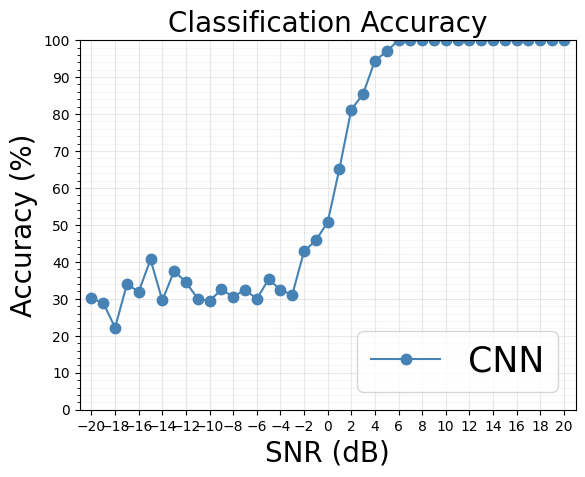

In [125]:
snr = range(-20, 21, 1)
acc = SNR_accuracy(snr, model_cnn, 'CNN')

# **MCLDNN**

In [18]:
from tensorflow.keras.layers import Input, Conv2D, Conv1D, LSTM, Dense, Dropout, Reshape, concatenate
from tensorflow.keras.models import Model
import argparse

parser = argparse.ArgumentParser(description="MCLDNN")
parser.add_argument("--filepath", type=str, default='./weights.h5', help='Path for saving and reloading the weight')
opt = parser.parse_args()


# Define input shapes
input_shape1=[2,128]
input_shape2=[128,1]

# Define dropout rate
dr = 0.4

In [19]:
# Define input layers
input1 = Input(input_shape1 + [1], name='IQchannel')
input2 = Input(input_shape2, name='Ichannel')
input3 = Input(input_shape2, name='Qchannel')

# Part-A: Multi-channel Inputs and Spatial Characteristics Mapping Section
x1 = Conv2D(50, (2, 8), padding='same', activation="relu", name="Conv1", kernel_initializer="glorot_uniform")(input1)

x2 = Conv1D(50, 8, padding='causal', activation="relu", name="Conv2", kernel_initializer="glorot_uniform")(input2)
x2_reshape = Reshape([-1, 128, 50])(x2)

x3 = Conv1D(50, 8, padding='causal', activation="relu", name="Conv3", kernel_initializer="glorot_uniform")(input3)
x3_reshape = Reshape([-1, 128, 50], name="reshap2")(x3)

x = concatenate([x2_reshape, x3_reshape], axis=1, name='Concatenate1')
x = Conv2D(50, (1, 8), padding='same', activation="relu", name="Conv4", kernel_initializer="glorot_uniform")(x)
x = concatenate([x1, x], name="Concatenate2")
x = Conv2D(100, (2, 5), padding="valid", activation="relu", name="Conv5", kernel_initializer="glorot_uniform")(x)

# Part-B: Temporal Characteristics Extraction Section
x = Reshape(target_shape=((124, 100)))(x)
x = LSTM(units=128, return_sequences=True, name="LSTM1")(x)
x = LSTM(units=128, name="LSTM2")(x)

# DNN
x = Dense(128, activation="selu", name="FC1")(x)
x = Dropout(dr)(x)
x = Dense(128, activation="selu", name="FC2")(x)
x = Dropout(dr)(x)
outputs = Dense(len(classes), activation="softmax", name="Softmax")(x)

# Create model
MCLDNN = Model(inputs=[input1, input2, input3], outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

MCLDNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [20]:
MCLDNN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Ichannel            │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Qchannel            │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv1D)      │ (None, 128, 50)   │        450 │ Ichannel[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv3 (Conv1D)      │ (None, 128, 50)   │        450 │ Qchannel[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128,    │          0 │ Conv2[0][0]       │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshap2 (Reshape)   │ (None, 1, 128,    │          0 │ Conv3[0][0]       │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ IQchannel           │ (None, 2, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate1        │ (None, 2, 128,    │          0 │ reshape[0][0],    │
│ (Concatenate)       │ 50)               │            │ reshap2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 2, 128,    │        850 │ IQchannel[0][0]   │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv4 (Conv2D)      │ (None, 2, 128,    │     20,050 │ Concatenate1[0][… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate2        │ (None, 2, 128,    │          0 │ Conv1[0][0],      │
│ (Concatenate)       │ 100)              │            │ Conv4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv5 (Conv2D)      │ (None, 1, 124,    │    100,100 │ Concatenate2[0][… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 124, 100)  │          0 │ Conv5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM1 (LSTM)        │ (None, 124, 128)  │    117,248 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM2 (LSTM)        │ (None, 128)       │    131,584 │ LSTM1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FC1 (Dense)         │ (None, 128)       │     16,512 │ LSTM2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ FC1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FC2 (Dense)         │ (None, 128)       │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ FC2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Softmax (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0] 

 Total params: 404,143 (1.54 MB)

 Trainable params: 404,143 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

# Data Preprocessing

In [21]:
# X_train.shape = (50400, 128, 1)
# X_test.shape = (6300, 128, 1)
# X_valid.shape = (6300, 128, 1)
 
# Select the data set of the real part and the imaginary part, separately
# and expand the data set dimension

# Split real part
X1_train = X_train.real.reshape(-1, 128, 1)
X1_test = X_test.real.reshape(-1, 128, 1)
X1_valid = X_valid.real.reshape(-1, 128, 1)

# Split imag part
X2_train = X_train.imag.reshape(-1, 128, 1)
X2_test = X_test.imag.reshape(-1, 128, 1)
X2_valid = X_valid.imag.reshape(-1, 128, 1)

# Concatenate real and imaginary parts
X3_train = np.concatenate([X1_train, X2_train], axis=-1).reshape(-1, 2, 128, 1)
X3_test = np.concatenate([X1_test, X2_test], axis=-1).reshape(-1, 2, 128, 1)
X3_valid = np.concatenate([X1_valid, X2_valid], axis=-1).reshape(-1, 2, 128, 1)

In [22]:
print(X1_train.shape)
print(X2_train.shape)
print(X3_train.shape)

(49200, 128, 1)
(49200, 128, 1)
(49200, 2, 128, 1)


In [23]:
history_MCLDNN = MCLDNN.fit(
    [X3_train, X1_train, X2_train],
    Y_train,
    batch_size=256,
    epochs=50,
    verbose=1,
    validation_data=([X3_valid, X1_valid, X2_valid], Y_valid),
    callbacks=[
        keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, verbose=1, patience=5, min_lr=0.0000001),
       keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
     ]
)

# We re-load the best weights once training is finished
# MCLDNN.load_weights(opt.filepath)

Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.3509 - loss: 1.0929
Epoch 1: val_loss improved from inf to 0.95989, saving model to best_model.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 125s 622ms/step - accuracy: 0.3511 - loss: 1.0927 - val_accuracy: 0.5218 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.5470 - loss: 0.9273
Epoch 2: val_loss improved from 0.95989 to 0.77620, saving model to best_model.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 128s 662ms/step - accuracy: 0.5472 - loss: 0.9271 - val_accuracy: 0.6405 - val_loss: 0.7762 - learning_rate: 0.0010
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.6316 - loss: 0.7863
Epoch 3: val_loss did not improve from 0.77620
193/193 ━━━━━━━━━━━━━━━━━━━━ 131s 679ms/step - accuracy: 0.6315 - loss: 0.7865 - val_accuracy: 0.4966 - val_loss: 0.8971 - learning_rate: 0.0010
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.5880 - loss: 0.8414


In [24]:
MCLDNN.save('MCLDNN_3.keras')

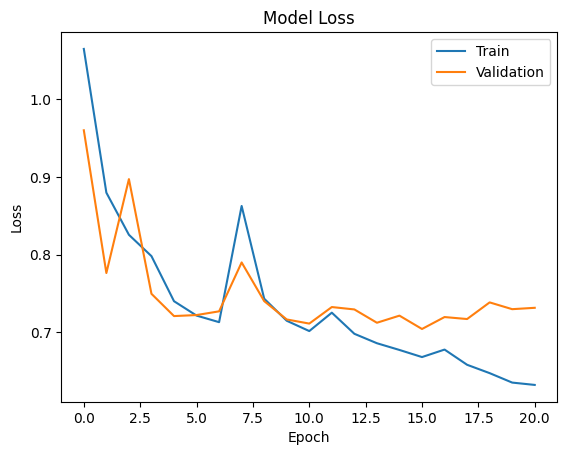

In [25]:
# Plot model loss (Train loss and Valid loss)
plt.plot(history_MCLDNN.history['loss'])
plt.plot(history_MCLDNN.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [26]:
# Evaluate model
test_loss, test_acc = MCLDNN.evaluate([X3_test, X1_test, X2_test], Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.6377 - loss: 0.7470
Test accuracy 0.6375609636306763
Test loss 0.7452133297920227


193/193 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step


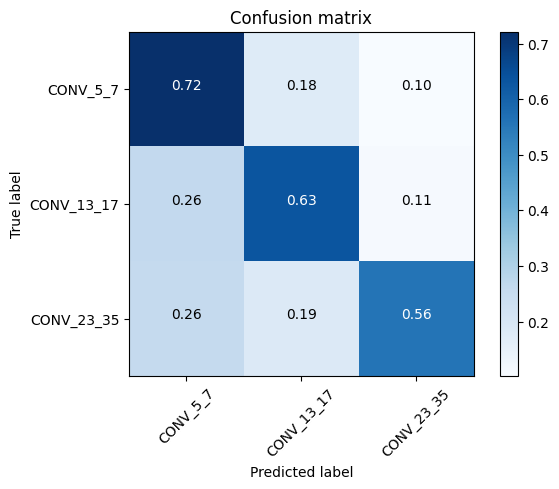

In [27]:
Y_predict = MCLDNN.predict([X3_test, X1_test, X2_test])

# Confusion matrix를 계산
conf = np.zeros([len(ch_code),len(ch_code)])
confnorm = np.zeros([len(ch_code),len(ch_code)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(Y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(ch_code)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
# Confusion matrix를 출력
plot_confusion_matrix(confnorm, labels=classes)

In [28]:
def SNR_accuracy_MC(in_snr, model, name):
    """
    Computes accuracies of chosen SNRs individually

    in_snr: must be list of SNRs
    """

    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR_t[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X1_test = X1_test[idx_acc_snr]  # Use real part of test data
        acc_X2_test = X2_test[idx_acc_snr]  # Use imaginary part of test data
        acc_X3_test = X3_test[idx_acc_snr]

        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X3_test, acc_X1_test, acc_X2_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(in_snr, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 21, 2)
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10)
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=10)


    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-21, 21)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
    plt.savefig(save_result_dir + name + '.png')
    plt.show()

    return acc[:,1]


In [1]:
snr = range(-20, 21, 1)
acc = SNR_accuracy_MC(snr, MCLDNN, 'MCLDNN')

NameError: name 'SNR_accuracy_MC' is not defined

# **CDSCNN**

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def _retrieve_elements_from_indices(tensor, indices):
    output = tensor.gather(dim=-1, index=indices).view_as(indices)
    return output

class ComplexMaxPool1d(nn.Module):
    """
    Complex-valued Maximum Pooling (CMP)
    """
    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, ceil_mode=False, return_indices=False, complex_axis=1):
        super(ComplexMaxPool1d, self).__init__()
        self.complex_axis = complex_axis
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.ceil_mode = ceil_mode
        
    def forward(self, inputs):
        real, imag = torch.chunk(inputs, 2, self.complex_axis)
        absolute_value = torch.abs(real + 1j*imag)
        absolute_value, indices = F.max_pool1d(absolute_value, kernel_size = self.kernel_size, stride = self.stride, 
                               padding = self.padding, dilation = self.dilation, ceil_mode = self.ceil_mode, return_indices = True)
        real = _retrieve_elements_from_indices(real, indices)
        imag = _retrieve_elements_from_indices(imag, indices)
        
        return torch.cat([real, imag], self.complex_axis)


class ComplexLinear(torch.nn.Module):
    """
    Complex-valued Fully Connection (CFC)
    """
    def __init__(self, in_features, out_features, complex_axis=1):
        super(ComplexLinear, self).__init__()
        self.in_features = in_features // 2
        self.out_features = out_features
        self.complex_axis = complex_axis
        self.real_linear = nn.Linear(self.in_features, self.out_features)
        self.imag_linear = nn.Linear(self.in_features, self.out_features)

    def forward(self, inputs):
        xr, xi = torch.chunk(inputs, 2, self.complex_axis)
        xr = xr.view(xr.size(0), -1)
        xi = xi.view(xi.size(0), -1)

        yrr = self.real_linear(xr)
        yri = self.imag_linear(xr)
        yir = self.real_linear(xi)
        yii = self.imag_linear(xi)

        yr = yrr - yii
        yi = yri + yir

        return torch.sqrt(torch.pow(yr, 2) + torch.pow(yi, 2))


class ComplexAvgPool2d(nn.Module):
    """
    Complex-Valued Average Pooling (CAP)
    """
    def __init__(self, output_size, complex_axis=1):
        super(ComplexAvgPool2d,self).__init__()
        self.output_size = output_size
        self.complex_axis = complex_axis

    def forward(self, inputs):
        real, imag = torch.chunk(inputs, 2, self.complex_axis)
        real = F.adaptive_avg_pool2d(real, self.output_size)
        imag = F.adaptive_avg_pool2d(imag, self.output_size)
        return torch.cat([real,imag], self.complex_axis)


class CReLU(nn.Module):
    """
    Complex-valued ReLU (CReLU)
    """
    def __init__(self, complex_axis=1, inplace=False):
        super(CReLU,self).__init__()
        self.r_relu = nn.ReLU(inplace=inplace)
        self.i_relu = nn.ReLU(inplace=inplace)
        self.complex_axis = complex_axis


    def forward(self, inputs):
        real, imag = torch.chunk(inputs, 2, self.complex_axis)
        real = self.r_relu(real)
        imag = self.i_relu(imag)
        return torch.cat([real,imag], self.complex_axis)

class ComplexConv1d(nn.Module):
    """
    Complex-valued Convolution (CC)
    """
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0,
                 dilation=1, groups=1, bias=False, complex_axis=1):

        super(ComplexConv1d, self).__init__()
        self.in_channels = in_channels // 2
        self.out_channels = out_channels // 2
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        if groups == in_channels:
            self.groups = groups // 2
        else:
            self.groups = 1
        self.dilation = dilation
        self.bias = bias
        self.complex_axis = complex_axis
        self.real_conv = nn.Conv1d(self.in_channels, self.out_channels, self.kernel_size, self.stride,
                                   self.padding, self.dilation, groups=self.groups, bias=self.bias)
        self.imag_conv = nn.Conv1d(self.in_channels, self.out_channels, self.kernel_size, self.stride,
                                   self.padding, self.dilation, groups=self.groups, bias=self.bias)
        
        nn.init.normal_(self.real_conv.weight.data, std=0.05)
        nn.init.normal_(self.imag_conv.weight.data, std=0.05)
        

    def forward(self, inputs):
        real, imag = torch.chunk(inputs, 2, self.complex_axis)

        real2real = self.real_conv(real)
        imag2imag = self.imag_conv(imag)
        
        real2imag = self.imag_conv(real)
        imag2real = self.real_conv(imag)

        real = real2real - imag2imag
        imag = real2imag + imag2real

        return torch.cat([real, imag], self.complex_axis)


# Source: https://github.com/ChihebTrabelsi/deep_complex_networks/tree/pytorch 
# from https://github.com/IMLHF/SE_DCUNet/blob/f28bf1661121c8901ad38149ea827693f1830715/models/layers/complexnn.py#L55

class ComplexBatchNorm(torch.nn.Module):
    """
    Complex-valued Batch Normalization (CBN)
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True, complex_axis=1):
        super(ComplexBatchNorm, self).__init__()
        self.num_features        = num_features // 2
        self.eps                 = eps
        self.momentum            = momentum
        self.affine              = affine
        self.track_running_stats = track_running_stats
        self.complex_axis = complex_axis

        if self.affine:
            self.Wrr = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Wri = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Wii = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Br  = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Bi  = torch.nn.Parameter(torch.Tensor(self.num_features))
        else:
            self.register_parameter('Wrr', None)
            self.register_parameter('Wri', None)
            self.register_parameter('Wii', None)
            self.register_parameter('Br',  None)
            self.register_parameter('Bi',  None)
        
        if self.track_running_stats:
            self.register_buffer('RMr',  torch.zeros(self.num_features))
            self.register_buffer('RMi',  torch.zeros(self.num_features))
            self.register_buffer('RVrr', torch.ones (self.num_features))
            self.register_buffer('RVri', torch.zeros(self.num_features))
            self.register_buffer('RVii', torch.ones (self.num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('RMr',                 None)
            self.register_parameter('RMi',                 None)
            self.register_parameter('RVrr',                None)
            self.register_parameter('RVri',                None)
            self.register_parameter('RVii',                None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.RMr.zero_()
            self.RMi.zero_()
            self.RVrr.fill_(1)
            self.RVri.zero_()
            self.RVii.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.Br.data.zero_()
            self.Bi.data.zero_()
            self.Wrr.data.fill_(1)
            self.Wri.data.uniform_(-.9, +.9) # W will be positive-definite
            self.Wii.data.fill_(1)

    def _check_input_dim(self, xr, xi):
        assert(xr.shape == xi.shape)
        assert(xr.size(1) == self.num_features)

    def forward(self, inputs):
        #self._check_input_dim(xr, xi)
        
        xr, xi = torch.chunk(inputs, 2, self.complex_axis)
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        #
        # NOTE: The precise meaning of the "training flag" is:
        #       True:  Normalize using batch   statistics, update running statistics
        #              if they are being collected.
        #       False: Normalize using running statistics, ignore batch   statistics.
        #
        training = self.training or not self.track_running_stats
        redux = [i for i in reversed(range(xr.dim())) if i!=1]
        vdim  = [1] * xr.dim()
        vdim[1] = xr.size(1)

        #
        # Mean M Computation and Centering
        #
        # Includes running mean update if training and running.
        #
        if training:
            Mr, Mi = xr, xi
            for d in redux:
                Mr = Mr.mean(d, keepdim=True)
                Mi = Mi.mean(d, keepdim=True)
            if self.track_running_stats:
                self.RMr.lerp_(Mr.squeeze(), exponential_average_factor)
                self.RMi.lerp_(Mi.squeeze(), exponential_average_factor)
        else:
            Mr = self.RMr.view(vdim)
            Mi = self.RMi.view(vdim)

        xr, xi = xr-Mr, xi-Mi

        #
        # Variance Matrix V Computation
        #
        # Includes epsilon numerical stabilizer/Tikhonov regularizer.
        # Includes running variance update if training and running.
        #
        if training:
            Vrr = xr * xr
            Vri = xr * xi
            Vii = xi * xi
            for d in redux:
                Vrr = Vrr.mean(d, keepdim=True)
                Vri = Vri.mean(d, keepdim=True)
                Vii = Vii.mean(d, keepdim=True)
            if self.track_running_stats:
                self.RVrr.lerp_(Vrr.squeeze(), exponential_average_factor)
                self.RVri.lerp_(Vri.squeeze(), exponential_average_factor)
                self.RVii.lerp_(Vii.squeeze(), exponential_average_factor)
        else:
            Vrr = self.RVrr.view(vdim)
            Vri = self.RVri.view(vdim)
            Vii = self.RVii.view(vdim)
        Vrr   = Vrr + self.eps
        Vri   = Vri
        Vii   = Vii + self.eps

        #
        # Matrix Inverse Square Root U = V^-0.5
        #
        # sqrt of a 2x2 matrix,
        # - https://en.wikipedia.org/wiki/Square_root_of_a_2_by_2_matrix
        tau   = Vrr + Vii
        delta = torch.addcmul(Vrr * Vii, Vri, Vri, value=-1)
        s     = delta.sqrt()
        t     = (tau + 2*s).sqrt()

        # matrix inverse, http://mathworld.wolfram.com/MatrixInverse.html
        rst   = (s * t).reciprocal()
        Urr   = (s + Vii) * rst
        Uii   = (s + Vrr) * rst
        Uri   = (  - Vri) * rst

        #
        # Optionally left-multiply U by affine weights W to produce combined
        # weights Z, left-multiply the inputs by Z, then optionally bias them.
        #
        # y = Zx + B
        # y = WUx + B
        # y = [Wrr Wri][Urr Uri] [xr] + [Br]
        #     [Wir Wii][Uir Uii] [xi]   [Bi]
        #
        if self.affine:
            Wrr, Wri, Wii = self.Wrr.view(vdim), self.Wri.view(vdim), self.Wii.view(vdim)
            Zrr = (Wrr * Urr) + (Wri * Uri)
            Zri = (Wrr * Uri) + (Wri * Uii)
            Zir = (Wri * Urr) + (Wii * Uri)
            Zii = (Wri * Uri) + (Wii * Uii)
        else:
            Zrr, Zri, Zir, Zii = Urr, Uri, Uri, Uii

        yr = (Zrr * xr) + (Zri * xi)
        yi = (Zir * xr) + (Zii * xi)

        if self.affine:
            yr = yr + self.Br.view(vdim)
            yi = yi + self.Bi.view(vdim)

        outputs = torch.cat([yr, yi], self.complex_axis)
        return outputs

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
                'track_running_stats={track_running_stats}'.format(**self.__dict__) 


In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CDSC1d(nn.Module):
    """
    The Complex-Valued Depthwise Separable Convolution (CDSC)
    """

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        """ Initialize a CDSC.

            Description of the Structure:
            A CDSC factorizes one regular convolution into one depthwise convolution (DWC) in the spatial dimension
            and one pointwise convolution (PWC) in the channel dimension.
            We perform the real-valued DWC in the spatial dimension and the complex-valued PWC in the channel dimension.
        """

        super(CDSC1d, self).__init__()

        self.DWC = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding, dilation,
                               groups=in_channels, bias=bias)
        self.PWC = ComplexConv1d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.DWC(x)
        x = self.PWC(x)
        return x

In [132]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides != 1:
            self.skip = ComplexConv1d(in_filters, out_filters, 1, stride=strides, bias=False)
            self.skipbn = ComplexBatchNorm(out_filters)
        else:
            self.skip = None

        self.relu = CReLU()
        rep = []

        filters = in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(CDSC1d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(ComplexBatchNorm(out_filters))
            filters = out_filters

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(CDSC1d(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(ComplexBatchNorm(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(CDSC1d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(ComplexBatchNorm(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = CReLU()

        if strides != 1:
            rep.append(ComplexMaxPool1d(3, strides, 1))
        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)
        x = x.cuda()

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp
        skip = skip.cuda()
        x += skip
        return x


class CDSCNN(nn.Module):
    """
    Complex-Valued Depthwise Separable Convolutional Neural Network (CDSCNN)
    """

    def __init__(self, num_classes):
        """ Initialize a CDSCNN
        Args:
            num_classes (int): the number of classes
        """
        super(CDSCNN, self).__init__()

        self.num_classes = num_classes

        self.conv1 = ComplexConv1d(2, 16, 3, 2, 0, bias=False)
        self.bn1 = ComplexBatchNorm(16)
        self.relu = CReLU()

        self.conv2 = ComplexConv1d(16, 32, 3, bias=False)
        self.bn2 = ComplexBatchNorm(32)

        self.block1 = Block(32, 64, 2, 2, start_with_relu=False, grow_first=True)
        self.block2 = Block(64, 128, 2, 2, start_with_relu=True, grow_first=True)

        self.block3 = Block(128, 128, 3, 1, start_with_relu=True, grow_first=True)
        self.block4 = Block(128, 128, 3, 1, start_with_relu=True, grow_first=True)
        self.block5 = Block(128, 128, 3, 1, start_with_relu=True, grow_first=True)
        self.block6 = Block(128, 128, 3, 1, start_with_relu=True, grow_first=True)
        self.block7 = Block(128, 128, 3, 1, start_with_relu=True, grow_first=True)
        self.block8 = Block(128, 128, 3, 1, start_with_relu=True, grow_first=True)
        self.block9 = Block(128, 128, 3, 1, start_with_relu=True, grow_first=True)

        self.block10 = Block(128, 256, 2, 2, start_with_relu=True, grow_first=False)

        self.conv3 = CDSC1d(256, 512, 3, 1, 1)
        self.bn3 = ComplexBatchNorm(512)

        self.avgpool = ComplexAvgPool2d((1, 1))
        self.fc = ComplexLinear(512, self.num_classes)

        # ------- init weights --------
        for m in self.modules():
            # print(m, flush=True)
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        # -----------------------------

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)

        x = self.block10(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = x.view(x.size(0), x.size(1), x.size(2), 1)

        x = self.avgpool(x)
        x = self.fc(x)
        return x

In [133]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader

def train_one_epoch(net, device, train_dataloader, optimizer, loss_func, LOSS, AC):
    """ training for one epoch
    Args:
        net: the classification model
        device: whether to use GPU
        train_dataloader: the training data loader
        optimizer: the optimization algorithm
        loss_func: the loss function
        LOSS: the list for recording the average loss for each epoch
        AC:  the list for recording the average accuracy for each epoch
    """
    net.train()
    Loss = 0
    ac = 0
    for i, (x, y) in enumerate(train_dataloader):
        x = x.float().to(device)
        y = y.long().to(device)
        optimizer.zero_grad()
        out = net(x)
        loss = loss_func(out, y)
        Loss += loss
        loss.backward()
        optimizer.step()
        ac += accuracy_score(y.cpu().data.numpy(), torch.max(out, 1)[1].cpu().data.numpy())
    LOSS.append(Loss / (i + 1))
    AC.append(ac / (i + 1))

In [134]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader


def val(net, device, val_dataloader, loss_func, val_LOSS, val_AC):
    """ validating for one epoch
        Args:
            net: the classification model
            device: whether to use GPU
            val_dataloader: the validation data loader
            loss_func: the loss function
            val_LOSS: the list for recording the average loss for each epoch
            val_AC: the list for recording the average accuracy for each epoch
    """
    net.eval()
    val_Loss = 0
    val_ac = 0
    with torch.no_grad():
        for i, (val_x, val_y) in enumerate(val_dataloader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            val_out = net(val_x)
            val_loss = loss_func(val_out, val_y)
            val_Loss += val_loss
            val_ac += accuracy_score(val_y.cpu().data.numpy(), torch.max(val_out, 1)[1].cpu().data.numpy())

        val_LOSS.append(val_Loss / (i + 1))
        val_AC.append(val_ac / (i + 1))

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CDSC1d(nn.Module):
    """
    The Complex-Valued Depthwise Separable Convolution (CDSC)
    """

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        """ Initialize a CDSC.

            Description of the Structure:
            A CDSC factorizes one regular convolution into one depthwise convolution (DWC) in the spatial dimension
            and one pointwise convolution (PWC) in the channel dimension.
            We perform the real-valued DWC in the spatial dimension and the complex-valued PWC in the channel dimension.
        """

        super(CDSC1d, self).__init__()

        self.DWC = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding, dilation,
                               groups=in_channels, bias=bias)
        self.PWC = ComplexConv1d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.DWC(x)
        x = self.PWC(x)
        return x

# **은재 제공 CNN**

In [105]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.models import Model

code_len = 128

excnn_in = Input(shape=(code_len, 1))

# 입력 차원 : [Batch_size, Feature_dimension, Time_step]
excnn_conv1 = Conv1D(filters=code_len, kernel_size=4,padding="same", activation="relu",kernel_initializer='he_normal')(excnn_in) 
excnn_pool1 = MaxPool1D(pool_size=1,strides=1)(excnn_conv1)
excnn_conv2 = Conv1D(filters=code_len,kernel_size=4,padding="same", activation="relu",kernel_initializer='he_normal')(excnn_pool1)
excnn_pool2 = MaxPool1D(pool_size=1,strides=1)(excnn_conv2)
excnn_conv3 = Conv1D(filters=code_len*2, kernel_size=4,padding="same", activation="relu",kernel_initializer='he_normal')(excnn_pool2)
excnn_flat1 = Flatten()(excnn_conv3)

excnn_dense1 = Dense(code_len, activation="relu",kernel_initializer='he_normal')(excnn_flat1)
excnn_out = Dense(len(classes), activation='softmax')(excnn_dense1)

existingCnnModel = Model(inputs = excnn_in, outputs = excnn_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

existingCnnModel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [106]:
existingCnnModel.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 128, 128)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 128, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 128, 256)       │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,392,451 (16.76 MB)

 Trainable params: 4,392,451 (16.76 MB)

 Non-trainable params: 0 (0.00 B)

In [137]:
history = existingCnnModel.fit(X_train, Y_train, epochs=10, batch_size=256, verbose=1, validation_data=(X_valid, Y_valid))

Epoch 1/10


197/197 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.9945 - loss: 0.0255 - val_accuracy: 0.9875 - val_loss: 0.0456
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.9940 - loss: 0.0361 - val_accuracy: 0.9921 - val_loss: 0.0314
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 43s 218ms/step - accuracy: 0.9959 - loss: 0.0214 - val_accuracy: 0.9927 - val_loss: 0.0310
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.9972 - loss: 0.0164 - val_accuracy: 0.9932 - val_loss: 0.0246
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - accuracy: 0.9957 - loss: 0.0222 - val_accuracy: 0.9927 - val_loss: 0.0303
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.9961 - loss: 0.0211 - val_accuracy: 0.9911 - val_loss: 0.0491
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.9947 - loss: 0.0266 - val_accuracy: 0.9929 - val_loss: 0.0268
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9956 - loss: 0.0208 - val

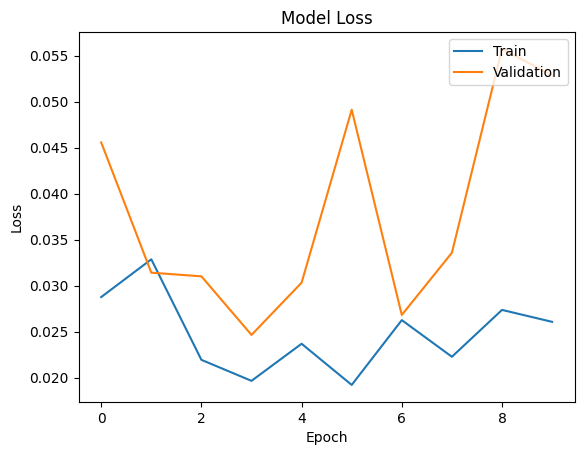

In [138]:
# Plot model loss (Train loss and Valid loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


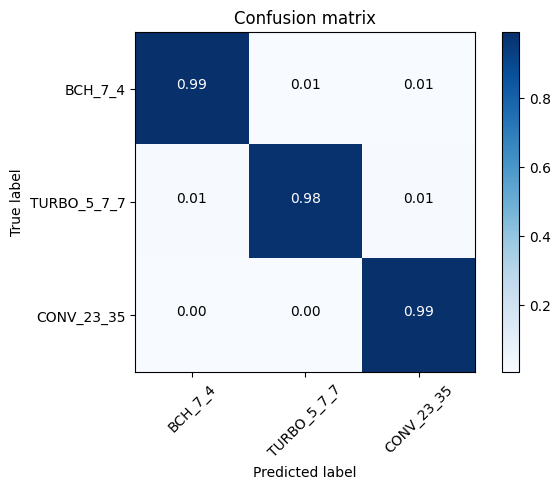

In [139]:
Y_predict = existingCnnModel.predict(X_test)

# Confusion matrix를 계산
conf = np.zeros([len(ch_code),len(ch_code)])
confnorm = np.zeros([len(ch_code),len(ch_code)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(Y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(ch_code)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
# Confusion matrix를 출력
plot_confusion_matrix(confnorm, labels=classes)


SNR -20dB:
10/10 - 0s - 28ms/step - accuracy: 0.8469 - loss: 0.4476

SNR -18dB:
10/10 - 0s - 12ms/step - accuracy: 0.9322 - loss: 0.3405

SNR -16dB:
11/11 - 0s - 12ms/step - accuracy: 0.9706 - loss: 0.1033

SNR -14dB:
9/9 - 0s - 12ms/step - accuracy: 0.9931 - loss: 0.0252

SNR -12dB:
10/10 - 0s - 12ms/step - accuracy: 0.9967 - loss: 0.0105

SNR -10dB:
11/11 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0050

SNR -8dB:
10/10 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0045

SNR -6dB:
10/10 - 0s - 11ms/step - accuracy: 0.9966 - loss: 0.0127

SNR -4dB:
10/10 - 0s - 11ms/step - accuracy: 0.9967 - loss: 0.0138

SNR -2dB:
9/9 - 0s - 11ms/step - accuracy: 0.9965 - loss: 0.0082

SNR 0dB:
10/10 - 0s - 11ms/step - accuracy: 0.9967 - loss: 0.0058

SNR 2dB:
10/10 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0013

SNR 4dB:
10/10 - 0s - 11ms/step - accuracy: 1.0000 - loss: 8.1507e-04

SNR 6dB:
10/10 - 0s - 11ms/step - accuracy: 1.0000 - loss: 2.6953e-04

SNR 8dB:
9/9 - 0s - 11ms/step - accuracy:

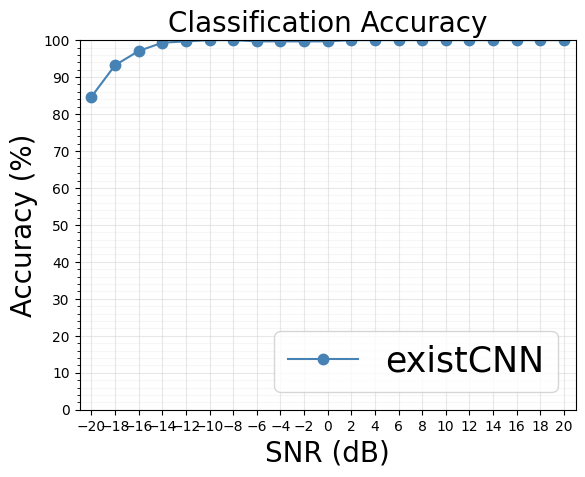

In [141]:
snr = range(-20, 21, 2)
acc = SNR_accuracy(snr, existingCnnModel, 'existCNN')